<a href="https://colab.research.google.com/github/natanrajch/subte_flow/blob/main/movimiento_pasajeros_subte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lectura datos

In [1]:
!pip install openpyxl --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd

In [3]:
#@title Cargar en sitio la base de datos completa.
#@markdown Hacer correr la celda (con el botón de "Play" que hay en la misma) y después hacer click en "Elegir archivos"

#upload la base de datos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('Se está utilizando la base de datos "{name}" de tamaño {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

filename = list(uploaded.keys())[0]


Saving base_20220511.xlsx to base_20220511.xlsx
Se está utilizando la base de datos "base_20220511.xlsx" de tamaño 25922234 bytes


In [6]:
#Leer base principal
df = pd.read_excel(filename) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828128 entries, 0 to 828127
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Fecha Hora   828128 non-null  datetime64[ns]
 1   Nro Tarjeta  828128 non-null  int64         
 2   Molinete     828128 non-null  object        
 3   Linea        828128 non-null  object        
 4   Estacion     828128 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 31.6+ MB


Chequear que los nombres de columna y orden de las mismas sea el mismo que el del archivo a utilizar:

 0   N°Tarjeta    int64         
 1   Linea        object        
 2   Estacion     object        
 3   Fecha        datetime64

 4   Hora         object     

In [8]:
#@title Cargar en sitio la planilla "info_tramos.xlsx"
#@markdown Hacer correr la celda (con el botón de "Play" que hay en la misma) y después hacer click en "Elegir archivos"

#upload la base de datos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('Se está utilizando la plainlla "{name}" de tamaño {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

filename = list(uploaded.keys())[0]

df_info_tramos = pd.read_excel(filename)
df_info_tramos.head()

Saving info_tramos.xlsx to info_tramos (1).xlsx
Se está utilizando la base de datos "info_tramos.xlsx" de tamaño 18061 Mb


,Tramo,Linea,Tramo_modificado_Espacio,sentido,Orden,mins_tramo,mins_desde_C1
0,Plaza de Mayo-Perú,A,Plaza de Mayo-Perú,Descendente,1,0.9667,26.5000
1,Perú-Piedras,A,Perú-Piedras,Descendente,2,1.1333,27.4667
2,Piedras-Lima,A,Piedras-Lima,Descendente,3,1.1500,28.6000
3,Lima-Sáenz Peña,A,Lima-Sáenz Peña,Descendente,4,1.1667,29.7500
4,Sáenz Peña-Congreso,A,Sáenz Peña-Congreso,Descendente,5,1.5333,30.9167


In [9]:
#@title Cargar en sitio la planilla de oferta
#@markdown * Ejemplo nombre archivo: oferta_vigente_20220511.xlsx  
#@markdown * Hacer correr la celda (con el botón de "Play" que hay en la misma) y después hacer click en "Elegir archivos"

#upload la base de datos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('Se está utilizando la planilla de oferta "{name}" de tamaño {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

filename = list(uploaded.keys())[0]

#@title Colocar fecha para archivo oferta. 

# fecha_oferta = '2022-05-11' #@param {type:"date"}
# fecha_oferta = fecha_oferta.replace('-','')

df_oferta_vigente = pd.read_excel(filename) 
#CHEQUEAR QUE TODOS LOS HORARIOS SEAN TIEMPO TIME Y NO TIEMPO DATETIME. PARA ESO, NO DEBE HABER HORAS QUE PASEN LAS 00:00
df_oferta_vigente.head()

Saving oferta_vigente_20220511.xlsx to oferta_vigente_20220511.xlsx
Se está utilizando la base de datos "oferta_vigente_20220511.xlsx" de tamaño 13767 Mb


,línea,inicio,fin,intervalo,inicio_extendido,fin_extendido,formaciones_hora,usuarios_sentados_promedio_formación,m2_promedio_formación,sentados_hora,m2_parados_hora
0,A,05:30:00,06:24:00,00:06:45,04:30:00,06:24:00,8.888889,180.0,121.0,1600.0,1075.555556
1,A,06:24:00,07:18:00,00:04:30,06:24:00,07:18:00,13.333333,180.0,121.0,2400.0,1613.333333
2,A,07:18:00,10:00:00,00:03:36,07:18:00,10:00:00,16.666667,180.0,121.0,3000.0,2016.666667
3,A,10:00:00,15:24:00,00:04:30,10:00:00,15:24:00,13.333333,180.0,121.0,2400.0,1613.333333
4,A,15:24:00,19:55:00,00:03:36,15:24:00,19:55:00,16.666667,180.0,121.0,3000.0,2016.666667


In [58]:
#@title INGRESAR TAMAÑO DE LA PARTICIÓN DEL DÍA, EN MINUTOS (por ej: cada 1, 5, 10, 15, 20, 30. Máximo 60)
bin_minutes = 15 #@param {type:"integer"}
if (60 % bin_minutes > 0) | (bin_minutes > 60):
  raise ValueError('SÓLO TRAMOS DIVISORES DE 60 Y CON 60 COMO MÁXIMO')

##Transformación de datos

In [11]:
#Cambio de nombre de columnas y creación de campo Fecha para base 11 de mayo 2022
if all([col in df.columns for col in ['Nro Tarjeta','Linea','Estacion', 'Fecha Hora']]): #Chequeo de que sea la base del 11 de mayo o similar
  df = df[['Nro Tarjeta','Linea','Estacion', 'Fecha Hora']].copy()
  df.rename(columns={'Nro Tarjeta':'N°Tarjeta', 'Fecha Hora':'Hora'}, inplace=True) 
  df['Fecha'] = df.Hora.apply(lambda row: row.date())

In [12]:
from sklearn.preprocessing import LabelEncoder
df["id"] = LabelEncoder().fit_transform(df['N°Tarjeta'])
df.drop("N°Tarjeta",axis=1,inplace=True)
df.head()

,Linea,Estacion,Hora,Fecha,id
0,Linea D,St_olleros,2022-05-11 05:10:00,2022-05-11,162205
1,Linea E,ST_RetiroE,2022-05-11 05:18:00,2022-05-11,338234
2,Linea E,ST_BOEDO,2022-05-11 05:19:00,2022-05-11,62370
3,Linea A,St_SanPedrito,2022-05-11 05:20:00,2022-05-11,185695
4,Linea A,St_SanPedrito,2022-05-11 05:20:00,2022-05-11,254247


In [13]:
#Quitar espacios de las columnas Línea y Estación
import re
df['Linea'] = df.Linea.apply(lambda l: re.sub("\s\s+" ," ", l).strip())
df['Estacion'] = df.Estacion.apply(lambda l: re.sub("\s\s+" ," ", l).strip())

In [14]:
#Normalizar estaciones y lineas para caso 11 de mayo 2022
normalizar_lineas_1 = {"Linea A":"Line A","Linea B":"Line B","Linea C":"Line C","Linea D":"Linea D","Linea E":"Line E","Linea H":"Linea H", "Linea P":"Line E"}
normalizar_estaciones_1 = {"ST_ACOYTE":"Acoyte","ST_ALBERTI":"Alberti","ST_CBARROS":"Castro Barros","ST_CONGRSA":"Congreso","ST_LIMA":"Lima","ST_LORIA":"Loria","ST_MISERER":"Miserere",
                           "ST_PERU":"Peru","ST_PIEDRAS":"Piedras","ST_PJUNTA":"Primera Junta","ST_PZAMAYO":"Plaza de Mayo","ST_RJANEIR":"Rio de Janeiro","ST_SNZPENA":"Saenz Pena",
                           "St_Flores":"Flores","St_SanPedrito":"SanPedrito","st_carabobo":"Carabobo","st_puan":"Puan","ST_ALEM":"Alem","ST_CALLAOB":"Callao_B","ST_CGARDEL":"Gardel",
                           "ST_DORREGO":"Dorrego","ST_FLORIDA":"Florida","ST_GALLARD":"Gallardo","ST_LACROZE":"Lacroze","ST_MALABIA":"Malabia","ST_MEDRANO":"Medrano","ST_PASTEUR":"Pasteur",
                           "ST_PELLEGR":"Pellegrini","ST_PUEYREB":"Pueyrredon_B","ST_URUGUAY":"Uruguay","St_Echeverria":"Echeverria","St_JMRosas":"JMRosas","st_losincas":"Los Incas",
                           "st_tronador":"Tronador","ST_AVMAYO":"Av. de Mayo","ST_CONSTIT":"Constitucion","ST_INDEPE":"Independencia_C","ST_LAVALLE":"Lavalle","ST_MORENOC":"Moreno C",
                           "ST_RETIRO":"Retiro","ST_SANJUAN":"San Juan","ST_SMARTIN":"San Martin","St_9JULIO":"Diagonal_Norte","St_9julio":"9 de Julio","St_aguero":"Aguero",
                           "St_bulnes":"Bulnes","St_callaod":"Callao_D","St_carranz":"Carranza","St_catedra":"Catedral","St_fmedici":"Facultad","St_hernand":"J_Hernandez",
                           "St_juramen":"Juramento","St_olleros":"Olleros","St_palermo":"Palermo","St_pitalia":"Plaza Italia","St_pueyred":"Pueyrredon_D","St_sortiz":"Scalabrini Ortiz",
                           "st_congrst":"Congreso_Tuc","st_tribuna":"Tribunales","ST_BELGRAN":"Belgrano","ST_BOEDO":"Boedo","ST_BOLIVAR":"Bolivar","ST_CCentral":"Correo Central",
                           "ST_Catalinas":"Catalinas","ST_EMITRE":"E Mitre","ST_ERIOS":"Entre Rio","ST_INDEPE":"Independencia_E","ST_JUJUY":"Jujuy","ST_LAPLATA":"La Plata",
                           "ST_MEDALLA":"Milagrosa","ST_MORENO":"Moreno","ST_PICHIN":"Pinchincha","ST_RetiroE":"RetiroE","ST_SANJOSE":"San Jose","ST_URQUIZA":"Urquiza",
                           "ST_VARELA":"Varela","ST_VIRREYE":"Virreyes","ST_SantaFe":"Santa Fe","St_Cordoba":"Cordoba","St_Fderecho":"FacultadDerecho","St_LasHeras":"LasHeras",
                           "st_caseros":"Caseros","st_corrient":"Corrientes","st_hospitales":"Hospitales","st_hprimo":"Humberto Primo","st_inclan":"Inclan","st_once":"Once",
                           "st_patricios":"Patricios","st_venezue":"Venezuela","St_Saguier":"Virreyes"}
df.Linea.replace(normalizar_lineas_1, inplace=True)
df.Estacion.replace(normalizar_estaciones_1, inplace=True)
df.loc[((df.Linea == 'Line C') & (df.Estacion == 'Independencia_E')), 'Estacion'] = 'Independencia_C'
df.head(2)

,Linea,Estacion,Hora,Fecha,id
0,Linea D,Olleros,2022-05-11 05:10:00,2022-05-11,162205
1,Line E,RetiroE,2022-05-11 05:18:00,2022-05-11,338234


In [15]:
df["nombre_completo"] = df['Linea'] + ' ' + df['Estacion']
df.sort_values(["id","Fecha","Hora"], inplace=True)
df.head(5)

,Linea,Estacion,Hora,Fecha,id,nombre_completo
726233,Line B,Gallardo,2022-05-11 18:53:00,2022-05-11,0,Line B Gallardo
124452,Line B,Lacroze,2022-05-11 08:30:00,2022-05-11,1,Line B Lacroze
667701,Line B,Florida,2022-05-11 18:04:00,2022-05-11,1,Line B Florida
75455,Linea H,Hospitales,2022-05-11 07:47:00,2022-05-11,2,Linea H Hospitales
487254,Linea H,Corrientes,2022-05-11 15:35:00,2022-05-11,2,Linea H Corrientes


In [16]:
#Se convierte el campo Hora de string hacia datetime. OJO que con la primera base este paso no hizo falta. Quizás haya que agregarle un IF para tener en cuenta diferentes bases
df['Hora'] = pd.to_datetime(df['Hora'],format= '%H:%M:%S' ).dt.time
df.head(3)

,Linea,Estacion,Hora,Fecha,id,nombre_completo
726233,Line B,Gallardo,18:53:00,2022-05-11,0,Line B Gallardo
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida


In [17]:
#Las entradas en Línea P Estación Metrovías se convierten en Línea E - Virreyes. Esto es una fuente posible de error, pero menor. Con los datos revisados, tiene más sentido tomar esto que eliminar las fichadas de Line P

df["nombre_completo"] = df.nombre_completo.replace({"Linea P METROVIAS":"Line E Virreyes"})
len(df[df.Estacion == "METROVIAS"])

0

In [18]:
#Modificar nombres para incorporar Combinaciones y el caso Pasco/Alberti -- "REVISAR CASO PASCO ALBERTI QUE NO ESTÁ BIEN REPRESENTADO EN EL DICT ""normalizar estaciones"" "
normalizar_combinaciones = {"Line A Lima":"Combinación A-C","Line A Miserere":"Combinación A-H","Line A Peru":"Combinación A-D-E","Line B Alem":"Combinación B-E",
                            "Line B Pellegrini":"Combinación B-C-D","Line B Pueyrredon_B":"Combinación B-H","Line C Av. de Mayo":"Combinación A-C",
                            "Line C Diagonal_Norte":"Combinación B-C-D","Line C Independencia_C":"Combinación C-E Ind","Line C Retiro":"Combinación C-E Ret",
                            "Line E Bolivar":"Combinación A-D-E","Line E Correo Central":"Combinación B-E","Line E Independencia_E":"Combinación C-E Ind","Line E Jujuy":"Combinación E-H",
                            "Line E RetiroE":"Combinación C-E Ret","Linea D 9 de Julio":"Combinación B-C-D","Linea D Catedral":"Combinación A-D-E","Linea D Pueyrredon_D":"Combinación D-H",
                            "Linea H Corrientes":"Combinación B-H","Linea H Humberto Primo":"Combinación E-H","Linea H Once":"Combinación A-H","Linea H Santa Fe":"Combinación D-H",
                            "Line A Pasco":"Line A Pasco-Alberti","Line A Alberti":"Line A Pasco-Alberti"}
df["estac_y_combins"] = df.nombre_completo.replace(normalizar_combinaciones)
print("REVISAR CASO PASCO ALBERTI QUE NO ESTÁ BIEN REPRESENTADO EN EL DICT ""normalizar combinaciones"" ","\n","\n")
df.head(20)

REVISAR CASO PASCO ALBERTI QUE NO ESTÁ BIEN REPRESENTADO EN EL DICT normalizar combinaciones  
 



,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins
726233,Line B,Gallardo,18:53:00,2022-05-11,0,Line B Gallardo,Line B Gallardo
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales
487254,Linea H,Corrientes,15:35:00,2022-05-11,2,Linea H Corrientes,Combinación B-H
221693,Line C,Constitucion,10:14:00,2022-05-11,3,Line C Constitucion,Line C Constitucion
349582,Line B,Alem,13:01:00,2022-05-11,3,Line B Alem,Combinación B-E
732413,Line B,Gardel,19:01:00,2022-05-11,3,Line B Gardel,Line B Gardel
296183,Linea H,Corrientes,12:00:00,2022-05-11,4,Linea H Corrientes,Combinación B-H
367898,Linea D,Palermo,13:19:00,2022-05-11,4,Linea D Palermo,Linea D Palermo


In [19]:
#Eliminar fichadas repetidas en misma estación
fichada_repetida = ((df.estac_y_combins.shift(-1) == df.estac_y_combins) & (df.id.shift(-1)==df.id))
df["fichada_repetida"] = fichada_repetida
df_norepeat = df[~fichada_repetida]
df_norepeat

,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,fichada_repetida
726233,Line B,Gallardo,18:53:00,2022-05-11,0,Line B Gallardo,Line B Gallardo,False
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,False
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,False
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales,False
487254,Linea H,Corrientes,15:35:00,2022-05-11,2,Linea H Corrientes,Combinación B-H,False
...,...,...,...,...,...,...,...,...
378028,Line B,Pellegrini,13:29:00,2022-05-11,488464,Line B Pellegrini,Combinación B-C-D,False
439671,Linea D,Olleros,14:40:00,2022-05-11,488465,Linea D Olleros,Linea D Olleros,False
790379,Line B,Florida,20:41:00,2022-05-11,488466,Line B Florida,Line B Florida,False
496030,Line B,Alem,15:45:00,2022-05-11,488467,Line B Alem,Combinación B-E,False


In [20]:
#Eliminar tarjetas con 1 sola transacción
conteo_fichadas = df_norepeat.id.map(df_norepeat.id.value_counts()) #value_counts devuelve algo tipo dict que se puede mapear
df2 = df_norepeat[conteo_fichadas > 1].copy() #Solo Tarjetas con al menos 2 fichadas
df2.drop("fichada_repetida", axis=1, inplace=True)
df2.head(2)


,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida


In [21]:
primer_ingreso = df2.groupby("id").first().nombre_completo
df2["primer_ingreso"] = df2.id.map(primer_ingreso)
df2.head(5)

,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,Line B Lacroze
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,Line B Lacroze
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales
487254,Linea H,Corrientes,15:35:00,2022-05-11,2,Linea H Corrientes,Combinación B-H,Linea H Hospitales
221693,Line C,Constitucion,10:14:00,2022-05-11,3,Line C Constitucion,Line C Constitucion,Line C Constitucion


In [22]:
df2["origen"] = df2.nombre_completo
df2["destino"] = df2.groupby("id").nombre_completo.shift(-1)
df2.destino.fillna(df2.primer_ingreso, inplace=True)
df2.head(6)

,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,Line B Lacroze,Line B Florida,Line B Lacroze
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Corrientes
487254,Linea H,Corrientes,15:35:00,2022-05-11,2,Linea H Corrientes,Combinación B-H,Linea H Hospitales,Linea H Corrientes,Linea H Hospitales
221693,Line C,Constitucion,10:14:00,2022-05-11,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line B Alem
349582,Line B,Alem,13:01:00,2022-05-11,3,Line B Alem,Combinación B-E,Line C Constitucion,Line B Alem,Line B Gardel


In [23]:
#Chequear que entre primer ingreso y último ingreso no sea la misma estación o nodo de combinación
check_vuelta_repetida = df2.origen.replace(normalizar_combinaciones) == df2.destino.replace(normalizar_combinaciones)
df3 = df2[~check_vuelta_repetida].copy()
df3.head(2)

,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,Line B Lacroze,Line B Florida,Line B Lacroze


In [24]:
df3[(df3.id>700)&(df.id<710)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino
44215,Linea D,Bulnes,07:19:00,2022-05-11,701,Linea D Bulnes,Linea D Bulnes,Linea D Bulnes,Linea D Bulnes,Linea D Facultad
549954,Linea D,Facultad,16:34:00,2022-05-11,701,Linea D Facultad,Linea D Facultad,Linea D Bulnes,Linea D Facultad,Linea D Bulnes
675731,Line A,Primera Junta,18:09:00,2022-05-11,702,Line A Primera Junta,Line A Primera Junta,Line A Primera Junta,Line A Primera Junta,Line A Peru
792429,Line A,Peru,20:46:00,2022-05-11,702,Line A Peru,Combinación A-D-E,Line A Primera Junta,Line A Peru,Line A Primera Junta
107352,Linea H,Humberto Primo,08:17:00,2022-05-11,703,Linea H Humberto Primo,Combinación E-H,Linea H Humberto Primo,Linea H Humberto Primo,Linea D Carranza
365135,Linea D,Carranza,13:16:00,2022-05-11,703,Linea D Carranza,Linea D Carranza,Linea H Humberto Primo,Linea D Carranza,Linea H Humberto Primo
170486,Line A,Puan,09:13:00,2022-05-11,705,Line A Puan,Line A Puan,Line A Puan,Line A Puan,Linea H LasHeras
700871,Linea H,LasHeras,18:26:00,2022-05-11,705,Linea H LasHeras,Linea H LasHeras,Line A Puan,Linea H LasHeras,Line A Puan
227225,Line A,Primera Junta,10:21:00,2022-05-11,707,Line A Primera Junta,Line A Primera Junta,Line A Primera Junta,Line A Primera Junta,Line A Peru
547011,Line A,Peru,16:31:00,2022-05-11,707,Line A Peru,Combinación A-D-E,Line A Primera Junta,Line A Peru,Line A Primera Junta


In [25]:
print('CANTIDAD DE FICHADAS SUBE DE ARCHIVO ORIGINAL:', len(df))
print('CANTIDAD DE FICHADAS CON MÁS DE 1 VIAJE EN EL MISMO DÍA:', len(df3))
print('PORCENTAJE SOBRE EL TOTAL:', "{0:.2%}".format(len(df3) / len(df)))

CANTIDAD DE FICHADAS SUBE DE ARCHIVO ORIGINAL: 828128
CANTIDAD DE FICHADAS CON MÁS DE 1 VIAJE EN EL MISMO DÍA: 556351
PORCENTAJE SOBRE EL TOTAL: 67.18%


In [26]:
normalizar_nombres = {"Line A Acoyte":"Acoyte","Line A Carabobo":"Carabobo","Line A Rio de Janeiro":"Río de Janeiro","Line A Alberti":"Pasco-Alberti",
                      "Line A Pasco":"Pasco-Alberti","Line A Castro Barros":"Castro Barros","Line A Congreso":"Congreso","Line A Flores":"San José de Flores",
                      "Line A Lima":"Lima","Line A Loria":"Loria","Line A Miserere":"Plaza Miserere","Line A Peru":"Perú","Line A Plaza de Mayo":"Plaza de Mayo",
                      "Line A Primera Junta":"Primera Junta","Line A Puan":"Puán","Line A SanPedrito":"San Pedrito","Line A Piedras":"Piedras","Line A Saenz Pena":"Sáenz Peña",
                      "Line B Alem":"Leandro N. Alem","Line B Callao_B":"Callao B","Line B Dorrego":"Dorrego","Line B Gallardo":"Angel Gallardo","Line B Echeverria":"Echeverría",
                      "Line B Gardel":"Carlos Gardel","Line B JMRosas":"Juan Manuel de Rosas","Line B Lacroze":"Federico Lacroze","Line B Los Incas":"Los Incas","Line B Malabia":"Malabia",
                      "Line B Medrano":"Medrano","Line B Pellegrini":"Carlos Pellegrini","Line B Pueyrredon_B":"Pueyrredón B","Line B Uruguay":"Uruguay","Line B Florida":"Florida",
                      "Line B Tronador":"Tronador","Line B Pasteur":"Pasteur","Line C Av. de Mayo":"Avenida de Mayo","Line C Constitucion":"Constitución",
                      "Line C Diagonal_Norte":"Diagonal Norte","Line C Independencia_C":"Independencia C","Line C Lavalle":"Lavalle","Line C Retiro":"Retiro C",
                      "Line C San Martin":"General San Martín","Line C Moreno C":"Moreno","Line C San Juan":"San Juan","Line E Boedo":"Boedo","Line E Bolivar":"Bolívar",
                      "Line E Correo Central":"Correo Central","Line E E Mitre":"Emilio Mitre","Line E Entre Rio":"Entre Ríos","Line E Independencia_E":"Independencia E",
                      "Line E Jujuy":"Jujuy","Line E La Plata":"La Plata","Line E Milagrosa":"Medalla Milagrosa","Line E Moreno":"José María Moreno","Line E RetiroE":"Retiro E",
                      "Line E Urquiza":"General Urquiza","Line E Virreyes":"Plaza de los Virreyes","Line E Varela":"Varela","Line E Pinchincha":"Pichincha","Line E San Jose":"San José",
                      "Line E Catalinas":"Catalinas","Line E Belgrano":"Belgrano","Linea D Aguero":"Agüero","Linea D 9 de Julio":"9 de Julio","Linea D Bulnes":"Bulnes",
                      "Linea D Callao_D":"Callao D","Linea D Carranza":"Ministro Carranza","Linea D Catedral":"Catedral","Linea D Congreso_Tuc":"Congreso de Tucumán",
                      "Linea D Facultad":"Facultad de Medicina","Linea D Juramento":"Juramento","Linea D Olleros":"Olleros","Linea D Palermo":"Palermo",
                      "Linea D Plaza Italia":"Plaza Italia","Linea D Pueyrredon_D":"Pueyrredón D","Linea D Scalabrini Ortiz":"Scalabrini Ortiz","Linea D J_Hernandez":"José Hernández",
                      "Linea D Tribunales":"Tribunales","Linea H Caseros":"Caseros","Linea H Corrientes":"Corrientes","Linea H FacultadDerecho":"Facultad de Derecho",
                      "Linea H Hospitales":"Hospitales","Linea H Humberto Primo":"Humberto 1","Linea H LasHeras":"Las Heras","Linea H Once":"Once","Linea H Patricios":"Parque Patricios",
                      "Linea H Santa Fe":"Santa Fe","Linea H Inclan":"Inclán","Linea H Cordoba":"Córdoba","Linea H Venezuela":"Venezuela"}

df3["origen_norm"] = df3.origen.replace(normalizar_nombres)
df3["destino_norm"] = df3.destino.replace(normalizar_nombres)
df3.head(3)

,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino,origen_norm,destino_norm
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida,Federico Lacroze,Florida
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,Line B Lacroze,Line B Florida,Line B Lacroze,Florida,Federico Lacroze
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Corrientes,Hospitales,Corrientes


In [27]:
#Time bins para expansión de datos a los totales de la base
minute_bins = [-1,30,60]
labels = ["00-30","31-59"]

df3["time_bins"] = df3.Hora.apply(lambda hora: "h:" + str(hora.hour) + ":m:") + pd.cut(df3.Hora.apply(lambda hora: hora.minute), bins=minute_bins, labels=labels).astype(str)
df3.head()

,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino,origen_norm,destino_norm,time_bins
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida,Federico Lacroze,Florida,h:8:m:00-30
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,Line B Lacroze,Line B Florida,Line B Lacroze,Florida,Federico Lacroze,h:18:m:00-30
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Corrientes,Hospitales,Corrientes,h:7:m:31-59
487254,Linea H,Corrientes,15:35:00,2022-05-11,2,Linea H Corrientes,Combinación B-H,Linea H Hospitales,Linea H Corrientes,Linea H Hospitales,Corrientes,Hospitales,h:15:m:31-59
221693,Line C,Constitucion,10:14:00,2022-05-11,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line B Alem,Constitución,Leandro N. Alem,h:10:m:00-30


In [28]:
#Chequear si todas las estaciones+time bins de df1 existen en df3
df["time_bins"] = df.Hora.apply(lambda hora: "h:" + str(hora.hour) + ":m:") + pd.cut(df.Hora.apply(lambda hora: hora.minute), bins=minute_bins, labels=labels).astype(str)

validaciones_estacion_timebin_df1 = df.groupby(["nombre_completo","time_bins"]).nombre_completo.count()
validaciones_estacion_timebin_df3 = df3.groupby(["nombre_completo","time_bins"]).nombre_completo.count()

estaciones_time_bins = df3.groupby(["nombre_completo","time_bins"]).destino.count().index
total = 0
for bin in df.groupby(["nombre_completo","time_bins"]).nombre_completo.count().index:
  if bin not in estaciones_time_bins:
    print(bin, validaciones_estacion_timebin_df1[bin])
    total += validaciones_estacion_timebin_df1[bin]
print("Casos no registrados:",total) 
#('Line A    Acoyte              ', 'h:10:m:00-14') in df3.groupby(["nombre_completo","time_bins"]).destino.count().index
#list(df3.groupby(["nombre_completo","time_bins","destino"]).destino.count().index[0])[:2]

('Line A Castro Barros', 'h:5:m:00-30') 2
('Line A Congreso', 'h:5:m:00-30') 1
('Line A Puan', 'h:5:m:00-30') 1
('Line B Dorrego', 'h:23:m:31-59') 1
('Line E Correo Central', 'h:5:m:00-30') 2
('Line E Entre Rio', 'h:5:m:00-30') 1
('Line E La Plata', 'h:5:m:00-30') 1
('Line E Milagrosa', 'h:5:m:00-30') 2
('Line E Virreyes', 'h:5:m:31-59') 1
('Linea D 9 de Julio', 'h:5:m:00-30') 1
('Linea D Bulnes', 'h:5:m:00-30') 1
('Linea D Catedral', 'h:5:m:00-30') 1
('Linea D Congreso_Tuc', 'h:23:m:31-59') 1
('Linea H Caseros', 'h:1:m:00-30') 2
('Linea H FacultadDerecho', 'h:5:m:00-30') 1
('Linea H Hospitales', 'h:23:m:31-59') 1
('Linea H LasHeras', 'h:5:m:00-30') 2
('Linea H Once', 'h:0:m:00-30') 1
Casos no registrados: 23


In [29]:
#Crear en df3 una columna con el proporcional de la validación conocida con origen destino al total de validaciones en df
#validaciones_estacion_timebin_destino_df3 = df3.groupby(["nombre_completo","time_bins","destino"]).nombre_completo.count()

df3["validaciones"] = df3.apply(lambda row: validaciones_estacion_timebin_df1[(row.nombre_completo, row.time_bins)] / validaciones_estacion_timebin_df3[(row.nombre_completo, row.time_bins)],
                                axis=1 )
df3.head()


,Linea,Estacion,Hora,Fecha,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino,origen_norm,destino_norm,time_bins,validaciones
124452,Line B,Lacroze,08:30:00,2022-05-11,1,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida,Federico Lacroze,Florida,h:8:m:00-30,1.311111
667701,Line B,Florida,18:04:00,2022-05-11,1,Line B Florida,Line B Florida,Line B Lacroze,Line B Florida,Line B Lacroze,Florida,Federico Lacroze,h:18:m:00-30,1.330946
75455,Linea H,Hospitales,07:47:00,2022-05-11,2,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Hospitales,Linea H Corrientes,Hospitales,Corrientes,h:7:m:31-59,1.702265
487254,Linea H,Corrientes,15:35:00,2022-05-11,2,Linea H Corrientes,Combinación B-H,Linea H Hospitales,Linea H Corrientes,Linea H Hospitales,Corrientes,Hospitales,h:15:m:31-59,1.528662
221693,Line C,Constitucion,10:14:00,2022-05-11,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line B Alem,Constitución,Leandro N. Alem,h:10:m:00-30,1.483193


In [30]:
print('Cantidad de casos eliminados en la expansión:', round(len(df) - sum(df3.validaciones),0), 'de un total de:', len(df))

Cantidad de casos eliminados en la expansión: 23.0 de un total de: 828128


##Cálculo Shortest Path

Edge Data from Subte GTFS
Linea E times between stations simplified into only one value (I guess it was some data noise in original gtfs)
Pasco y Alberti joined into one station
Correo Central, Catalinas and Retiro E manually added to gtfs data


In [31]:
import networkx as nx

In [32]:
nodes = ["Plaza de Mayo","Perú","Piedras","Lima","Sáenz Peña","Congreso","Pasco-Alberti","Plaza Miserere","Loria","Castro Barros","Río de Janeiro","Acoyte","Primera Junta","Puán","Carabobo","San José de Flores","San Pedrito","Leandro N. Alem","Florida","Carlos Pellegrini","Uruguay","Callao B","Pasteur","Pueyrredón B","Carlos Gardel","Medrano","Angel Gallardo","Malabia","Dorrego","Federico Lacroze","Tronador","Los Incas","Echeverría","Juan Manuel de Rosas","Retiro C","General San Martín","Lavalle","Diagonal Norte","Avenida de Mayo","Moreno","Independencia C","San Juan","Constitución","Catedral","9 de Julio","Tribunales","Callao D","Facultad de Medicina","Pueyrredón D","Agüero","Bulnes","Scalabrini Ortiz","Plaza Italia","Palermo","Ministro Carranza","Olleros","José Hernández","Juramento","Congreso de Tucumán","Retiro E","Catalinas","Correo Central","Bolívar","Belgrano","Independencia E","San José","Entre Ríos","Pichincha","Jujuy","General Urquiza","Boedo","La Plata","José María Moreno","Emilio Mitre","Medalla Milagrosa","Varela","Plaza de los Virreyes","Facultad de Derecho","Las Heras","Santa Fe","Córdoba","Corrientes","Once","Venezuela","Humberto 1","Inclán","Caseros","Parque Patricios","Hospitales"]

In [33]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

In [34]:
edges = [["9 de Julio","Carlos Pellegrini",3.1000],["9 de Julio","Diagonal Norte",5.4000],["Avenida de Mayo","Lima",3.1000],["Bolívar","Catedral",5.4000],["Bolívar","Perú",3.4000],["Carlos Pellegrini","9 de Julio",3.1000],["Carlos Pellegrini","Diagonal Norte",6.0000],["Catedral","Bolívar",5.4000],["Catedral","Perú",3.1000],["Corrientes","Pueyrredón B",3.1000],["Diagonal Norte","9 de Julio",5.4000],["Diagonal Norte","Carlos Pellegrini",6.0000],["Humberto 1","Jujuy",3.1000],["Independencia C","Independencia E",3.7000],["Independencia E","Independencia C",3.7000],["Jujuy","Humberto 1",3.1000],["Lima","Avenida de Mayo",3.1000],["Once","Plaza Miserere",3.1000],["Perú","Bolívar",3.4000],["Perú","Catedral",3.1000],["Plaza Miserere","Once",3.1000],["Pueyrredón B","Corrientes",3.1000],["Pueyrredón D","Santa Fe",3.1000],["Santa Fe","Pueyrredón D",3.1000],["Acoyte","Primera Junta",1.5500],["Acoyte","Río de Janeiro",1.7833],["Pasco-Alberti","Plaza Miserere",1.5833],["Carabobo","Puán",1.8833],["Carabobo","San José de Flores",1.9333],["Castro Barros","Loria",1.6500],["Castro Barros","Río de Janeiro",2.0000],["Congreso","Pasco-Alberti",1.5833],["Congreso","Sáenz Peña",1.5333],["Lima","Piedras",1.1500],["Lima","Sáenz Peña",1.1667],["Loria","Castro Barros",1.6500],["Loria","Plaza Miserere",2.2833],["Pasco-Alberti","Congreso",1.5833],["Perú","Piedras",1.1333],["Perú","Plaza de Mayo",0.9667],["Piedras","Lima",1.1500],["Piedras","Perú",1.1333],["Plaza de Mayo","Perú",0.9667],["Plaza Miserere","Loria",2.2833],["Plaza Miserere","Pasco-Alberti",1.5833],["Primera Junta","Acoyte",1.5500],["Primera Junta","Puán",1.9333],["Puán","Carabobo",1.8833],["Puán","Primera Junta",1.9333],["Río de Janeiro","Acoyte",1.7833],["Río de Janeiro","Castro Barros",2.0000],["Sáenz Peña","Congreso",1.5333],["Sáenz Peña","Lima",1.1667],["San José de Flores","Carabobo",1.9333],["San José de Flores","San Pedrito",1.7500],["San Pedrito","San José de Flores",1.7500],["Angel Gallardo","Malabia",1.9333],["Angel Gallardo","Medrano",1.9500],["Callao B","Pasteur",1.4333],["Callao B","Uruguay",1.3167],["Carlos Gardel","Medrano",1.9500],["Carlos Gardel","Pueyrredón B",1.4667],["Carlos Pellegrini","Florida",1.4833],["Carlos Pellegrini","Uruguay",1.3167],["Dorrego","Federico Lacroze",1.7167],["Dorrego","Malabia",2.3000],["Echeverría","Juan Manuel de Rosas",1.6167],["Echeverría","Los Incas",1.9167],["Federico Lacroze","Dorrego",1.7167],["Federico Lacroze","Tronador",2.3500],["Florida","Carlos Pellegrini",1.4833],["Florida","Leandro N. Alem",1.1167],["Juan Manuel de Rosas","Echeverría",1.6167],["Leandro N. Alem","Florida",1.1167],["Los Incas","Echeverría",1.9167],["Los Incas","Tronador",1.6500],["Malabia","Angel Gallardo",1.9333],["Malabia","Dorrego",2.3000],["Medrano","Angel Gallardo",1.9500],["Medrano","Carlos Gardel",1.9500],["Pasteur","Callao B",1.4333],["Pasteur","Pueyrredón B",1.3333],["Pueyrredón B","Carlos Gardel",1.4667],["Pueyrredón B","Pasteur",1.3333],["Tronador","Federico Lacroze",2.3500],["Tronador","Los Incas",1.6500],["Uruguay","Callao B",1.3167],["Uruguay","Carlos Pellegrini",1.3167],["Avenida de Mayo","Diagonal Norte",1.6667],["Avenida de Mayo","Moreno",1.3000],["Constitución","San Juan",1.6500],["Diagonal Norte","Avenida de Mayo",1.6667],["Diagonal Norte","Lavalle",1.3500],["General San Martín","Lavalle",2.2500],["General San Martín","Retiro C",1.3000],["Independencia C","Moreno",1.8167],["Independencia C","San Juan",1.5833],["Lavalle","Diagonal Norte",1.3500],["Lavalle","General San Martín",2.2500],["Moreno","Avenida de Mayo",1.3000],["Moreno","Independencia C",1.8167],["Retiro C","General San Martín",1.3000],["San Juan","Constitución",1.6500],["San Juan","Independencia C",1.5833],["9 de Julio","Catedral",1.6833],["9 de Julio","Tribunales",1.3167],["Agüero","Bulnes",1.4333],["Agüero","Pueyrredón D",1.4000],["Bulnes","Agüero",1.4333],["Bulnes","Scalabrini Ortiz",1.4500],["Callao D","Facultad de Medicina",1.3000],["Callao D","Tribunales",1.9833],["Catedral","9 de Julio",1.6833],["Congreso de Tucumán","Juramento",2.1500],["Facultad de Medicina","Callao D",1.3000],["Facultad de Medicina","Pueyrredón D",2.0000],["José Hernández","Juramento",1.5167],["José Hernández","Olleros",2.0000],["Juramento","Congreso de Tucumán",2.1500],["Juramento","José Hernández",1.5167],["Ministro Carranza","Olleros",2.4167],["Ministro Carranza","Palermo",2.1333],["Olleros","José Hernández",2.0000],["Olleros","Ministro Carranza",2.4167],["Palermo","Ministro Carranza",2.1333],["Palermo","Plaza Italia",1.5000],["Plaza Italia","Palermo",1.5000],["Plaza Italia","Scalabrini Ortiz",1.5667],["Pueyrredón D","Agüero",1.4000],["Pueyrredón D","Facultad de Medicina",2.0000],["Scalabrini Ortiz","Bulnes",1.4500],["Scalabrini Ortiz","Plaza Italia",1.5667],["Tribunales","9 de Julio",1.3167],["Tribunales","Callao D",1.9833],["Belgrano","Bolívar",1.5000],["Belgrano","Independencia E",1.5333],["Boedo","General Urquiza",1.6500],["Boedo","La Plata",2.0167],["Bolívar","Belgrano",1.5000],["Emilio Mitre","José María Moreno",2.1167],["Emilio Mitre","Medalla Milagrosa",2.1500],["Entre Ríos","Pichincha",1.3833],["Entre Ríos","San José",1.5000],["General Urquiza","Boedo",1.6500],["General Urquiza","Jujuy",1.6000],["Independencia E","Belgrano",1.5333],["Independencia E","San José",1.8000],["José María Moreno","Emilio Mitre",2.1167],["José María Moreno","La Plata",1.9333],["Jujuy","General Urquiza",1.6000],["Jujuy","Pichincha",1.4000],["La Plata","Boedo",2.0167],["La Plata","José María Moreno",1.9333],["Medalla Milagrosa","Emilio Mitre",2.1500],["Medalla Milagrosa","Varela",1.9500],["Pichincha","Entre Ríos",1.3833],["Pichincha","Jujuy",1.4000],["Plaza de los Virreyes","Varela",1.3333],["San José","Entre Ríos",1.5000],["San José","Independencia E",1.8000],["Varela","Medalla Milagrosa",1.9500],["Varela","Plaza de los Virreyes",1.3333],["Caseros","Inclán",1.6667],["Caseros","Parque Patricios",2.0167],["Córdoba","Corrientes",1.5000],["Córdoba","Santa Fe",1.2167],["Corrientes","Córdoba",1.5000],["Corrientes","Once",1.5000],["Facultad de Derecho","Las Heras",1.6500],["Hospitales","Parque Patricios",1.8667],["Humberto 1","Inclán",1.7000],["Humberto 1","Venezuela",2.0833],["Inclán","Caseros",1.6667],["Inclán","Humberto 1",1.7000],["Las Heras","Facultad de Derecho",1.6500],["Las Heras","Santa Fe",2.0667],["Once","Corrientes",1.5000],["Once","Venezuela",1.6667],["Parque Patricios","Caseros",2.0167],["Parque Patricios","Hospitales",1.8667],["Santa Fe","Córdoba",1.2167],["Santa Fe","Las Heras",2.0667],["Venezuela","Humberto 1",2.0833],["Venezuela","Once",1.6667],["Bolívar","Correo Central",2.3739],["Correo Central","Bolívar",2.3739],["Catalinas","Correo Central",2.0391],["Correo Central","Catalinas",2.0391],["Retiro E","Catalinas",1.6961],["Catalinas","Retiro E",1.6961],["Retiro E","Retiro C",3.1000],["Retiro C","Retiro E",3.1000],["Correo Central","Leandro N. Alem",3.1000],["Leandro N. Alem","Correo Central",3.1000]]
for edge in edges:
  u,v,weight=edge
  G.add_edge(u, v, weight=weight)

In [35]:
shortest_paths = {}
for node in nodes:
  shortest_paths[node] = nx.shortest_path(G,source=node, weight="weight")


In [36]:
from collections import defaultdict
edges_weights = defaultdict(dict)
for edge in edges:
  u,v,weight=edge
  edges_weights[u][v] = weight

## Combinación Datos Molinetes con Shortest Path para crear un df de movimientos en el Subte

In [37]:
from datetime import timedelta
from datetime import datetime
from datetime import date


tramos = []
horas = []
validaciones = []
sube_baja = []
origenes=[]
destinos=[]
for row in df3.itertuples():
  path = shortest_paths[row.origen_norm][row.destino_norm]
  mins_acum = 0
  for i in range(len(path)-1):
    origen = path[i]
    destino = path[i+1]
    tramos.append(origen + "-" + destino)
    horas.append((datetime.combine(date(100,1,1),row.Hora) + timedelta(minutes=mins_acum)).time())
    validaciones.append(row.validaciones)
    if i == 0:
      sube_baja.append("sube")
    elif i == (len(path) - 2):
      sube_baja.append("baja")
    else:
      sube_baja.append("-")
    origenes.append(origen)
    destinos.append(destino)
    mins_acum += edges_weights[origen][destino]

In [38]:
  len(tramos), len(horas), len(validaciones), len(sube_baja), len(origenes), len(destinos)

(5119061, 5119061, 5119061, 5119061, 5119061, 5119061)

To DO: **Expandir tomando de franquiciados**  
El total de tarjetas se puede realizar con los datos de molinetes, aunque sería bueno tomar la otra base que incluye también a los franquiciados.

In [39]:
cargadf = pd.DataFrame(list(zip(tramos, horas, validaciones,sube_baja, origenes, destinos)),
               columns =['tramos', 'horas','pasajeros','sube_baja', 'origen', 'destino'])
cargadf.head(20)

,tramos,horas,pasajeros,sube_baja,origen,destino
0,Federico Lacroze-Dorrego,08:30:00,1.311111,sube,Federico Lacroze,Dorrego
1,Dorrego-Malabia,08:31:43.002000,1.311111,-,Dorrego,Malabia
2,Malabia-Angel Gallardo,08:34:01.002000,1.311111,-,Malabia,Angel Gallardo
3,Angel Gallardo-Medrano,08:35:57,1.311111,-,Angel Gallardo,Medrano
4,Medrano-Carlos Gardel,08:37:54,1.311111,-,Medrano,Carlos Gardel
5,Carlos Gardel-Pueyrredón B,08:39:51,1.311111,-,Carlos Gardel,Pueyrredón B
6,Pueyrredón B-Pasteur,08:41:19.002000,1.311111,-,Pueyrredón B,Pasteur
7,Pasteur-Callao B,08:42:39,1.311111,-,Pasteur,Callao B
8,Callao B-Uruguay,08:44:04.998000,1.311111,-,Callao B,Uruguay
9,Uruguay-Carlos Pellegrini,08:45:24,1.311111,-,Uruguay,Carlos Pellegrini


In [40]:
#Chequeo que los tramos en el df de info tramos sean únicos
print('Tramo_modificado_Espacio es único:', df_info_tramos.Tramo_modificado_Espacio.is_unique)

#Genero un DICT con la info de los tramos para más velocidad de acceso a los datos
info_tramos_dict = defaultdict(dict)
for row in df_info_tramos.itertuples():
  info_tramos_dict[row.Tramo_modificado_Espacio]['linea'] = row.Linea
  info_tramos_dict[row.Tramo_modificado_Espacio]['sentido'] = row.sentido
  info_tramos_dict[row.Tramo_modificado_Espacio]['mins_desde_C1'] = row.mins_desde_C1


Tramo_modificado_Espacio es único: True


In [41]:
cargadf = cargadf.merge(df_info_tramos,how='left', left_on='tramos', right_on='Tramo_modificado_Espacio').drop(['Tramo','Tramo_modificado_Espacio'], axis=1)
cargadf.head(2)

,tramos,horas,pasajeros,sube_baja,origen,destino,Linea,sentido,Orden,mins_tramo,mins_desde_C1
0,Federico Lacroze-Dorrego,08:30:00,1.311111,sube,Federico Lacroze,Dorrego,B,Ascendente,12.0,1.7167,7.5334
1,Dorrego-Malabia,08:31:43.002000,1.311111,-,Dorrego,Malabia,B,Ascendente,11.0,2.3000,9.2501


In [59]:
bins = [-1]
bins.extend([(bin_minutes + bin_minutes * i) for i in range(int(60 / bin_minutes))])
labels= [i*bin_minutes for i in range(len(bins)-1)]
labels_text= ['{0:0>2}'.format(str(bins[i]+1))+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
cargadf["time_bin_num"] = cargadf.horas.apply(lambda hora: hora.hour * 100) + pd.cut(cargadf.horas.apply(lambda hora: hora.minute),bins=bins, labels=labels).astype(int)
cargadf["time_bin"] = cargadf.horas.apply(lambda hora: '{0:0>2}'.format(str(hora.hour))+":") + pd.cut(cargadf.horas.apply(lambda hora: hora.minute),bins=bins, labels=labels_text).astype(str)
cargadf.head(5)

,tramos,horas,pasajeros,sube_baja,origen,destino,Linea,sentido,Orden,mins_tramo,mins_desde_C1,time_bin_num,time_bin
0,Federico Lacroze-Dorrego,08:30:00,1.311111,sube,Federico Lacroze,Dorrego,B,Ascendente,12.0,1.7167,7.5334,825,08:26-30
1,Dorrego-Malabia,08:31:43.002000,1.311111,-,Dorrego,Malabia,B,Ascendente,11.0,2.3000,9.2501,830,08:31-35
2,Malabia-Angel Gallardo,08:34:01.002000,1.311111,-,Malabia,Angel Gallardo,B,Ascendente,10.0,1.9333,11.5501,830,08:31-35
3,Angel Gallardo-Medrano,08:35:57,1.311111,-,Angel Gallardo,Medrano,B,Ascendente,9.0,1.9500,13.4834,830,08:31-35
4,Medrano-Carlos Gardel,08:37:54,1.311111,-,Medrano,Carlos Gardel,B,Ascendente,8.0,1.9500,15.4334,835,08:36-40


In [60]:
pasajeros_hora_df = (cargadf.groupby(['tramos','time_bin_num']).agg('sum')
                    .reset_index().merge(df_info_tramos[['Tramo_modificado_Espacio','Linea','mins_desde_C1']],how='left', left_on='tramos', right_on='Tramo_modificado_Espacio')
                    .drop(['Tramo_modificado_Espacio'], axis=1))
pasajeros_hora_df.fillna('Combinación', inplace=True)
pasajeros_hora_df['pasajeros_hora'] = pasajeros_hora_df.pasajeros * int(60 / bin_minutes)
pasajeros_hora_df.tail(2)

,tramos,time_bin_num,pasajeros,Orden,mins_tramo,mins_desde_C1_x,Linea,mins_desde_C1_y,pasajeros_hora
41882,Venezuela-Once,2340,2.0,6.0,1.6667,29.9334,H,29.9334,24.0
41883,Venezuela-Once,2355,2.0,6.0,1.6667,29.9334,H,29.9334,24.0


##Oferta y Ocupacion

In [61]:
ocupacion_hora_df = pasajeros_hora_df.copy()

In [62]:
from datetime import time
def calc_oferta_hora(row,tipo):
  hora_bin = int((row.time_bin_num - (row.time_bin_num % 100)) /100) #obtener hora
  minutos_bin = row.time_bin_num % 100  + int(bin_minutes/2)  #Obtener los minutos (se toma tramo intermedio del bin, es decir, a los +5 minutos de bins de 10 min)
  if row.mins_desde_C1_y == 'Combinación':
    mins_desde_C1 = 0
  else:
    mins_desde_C1 = row.mins_desde_C1_y

  #Se eleva el hora_bin a datetime para poder restarle los mins desde C1
  tiempo = (datetime.combine(date(1988,1,1),time(hora_bin,minutos_bin,0)) - timedelta(minutes=mins_desde_C1)).time()
  oferta_hora = df_oferta_vigente[(df_oferta_vigente['inicio_extendido'] < tiempo) & 
                           (df_oferta_vigente['fin_extendido'] >= tiempo) &
                           (df_oferta_vigente['línea'] == row.Linea)][tipo].values
  if oferta_hora.size > 0:
    return oferta_hora[0]
  return 0


In [63]:
ocupacion_hora_df['sentados_hora'] = ocupacion_hora_df.apply(lambda row: calc_oferta_hora(row,'sentados_hora'), axis=1)
ocupacion_hora_df['m2_parados_hora'] = ocupacion_hora_df.apply(lambda row: calc_oferta_hora(row,'m2_parados_hora'), axis=1)
ocupacion_hora_df.tail(3)

,tramos,time_bin_num,pasajeros,Orden,mins_tramo,mins_desde_C1_x,Linea,mins_desde_C1_y,pasajeros_hora,sentados_hora,m2_parados_hora
41881,Venezuela-Once,2330,2.133333,12.0,3.3334,59.8668,H,29.9334,25.6,1701.818182,1167.545455
41882,Venezuela-Once,2340,2.000000,6.0,1.6667,29.9334,H,29.9334,24.0,1701.818182,1167.545455
41883,Venezuela-Once,2355,2.000000,6.0,1.6667,29.9334,H,29.9334,24.0,1701.818182,1167.545455


In [64]:
#Cálculo de OCUPACIÓN
def calc_ocupacion(row):
  if row.m2_parados_hora > 0:
    return max([0, row.pasajeros_hora - row.sentados_hora])/row.m2_parados_hora
  return "-"
ocupacion_hora_df['ocupación_pas_x_m2'] = ocupacion_hora_df.apply(calc_ocupacion,axis=1)
#Se quitan los tramos de combinación para el cálculo de la ocupación máxima por tramo
ocupacion_hora_df = ocupacion_hora_df[ocupacion_hora_df.Linea != 'Combinación'].copy()
ocupacion_hora_df.tail(5)

,tramos,time_bin_num,pasajeros,Orden,mins_tramo,mins_desde_C1_x,Linea,mins_desde_C1_y,pasajeros_hora,sentados_hora,m2_parados_hora,ocupación_pas_x_m2
41879,Venezuela-Once,2320,5.264646,24.0,6.6668,119.7336,H,29.9334,63.175758,1701.818182,1167.545455,0.0
41880,Venezuela-Once,2325,2.000000,6.0,1.6667,29.9334,H,29.9334,24.000000,1701.818182,1167.545455,0.0
41881,Venezuela-Once,2330,2.133333,12.0,3.3334,59.8668,H,29.9334,25.600000,1701.818182,1167.545455,0.0
41882,Venezuela-Once,2340,2.000000,6.0,1.6667,29.9334,H,29.9334,24.000000,1701.818182,1167.545455,0.0
41883,Venezuela-Once,2355,2.000000,6.0,1.6667,29.9334,H,29.9334,24.000000,1701.818182,1167.545455,0.0


In [65]:
tramos_cargas_timebin_df = pd.pivot_table(cargadf, values="pasajeros", columns="time_bin", index="tramos", aggfunc="sum").fillna(0) * (60 / bin_minutes)
tramos_cargas_timebin_df.head(2)

time_bin,00:00-5,00:06-10,00:11-15,00:16-20,05:06-10,05:11-15,05:16-20,05:21-25,05:26-30,05:31-35,...,23:11-15,23:16-20,23:21-25,23:26-30,23:31-35,23:36-40,23:41-45,23:46-50,23:51-55,23:56-60
tramos,,,,,,,,,,,,,,,,,,,,,
9 de Julio-Carlos Pellegrini,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.333333,51.516883,14.0,14.571429,0.0,0.0,0.0,0.0,0.0,0.0
9 de Julio-Catedral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,63.778904,69.490909,0.0,15.804878,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
cargadf

,tramos,horas,pasajeros,sube_baja,origen,destino,Linea,sentido,Orden,mins_tramo,mins_desde_C1,time_bin_num,time_bin
0,Federico Lacroze-Dorrego,08:30:00,1.311111,sube,Federico Lacroze,Dorrego,B,Ascendente,12.0,1.7167,7.5334,825,08:26-30
1,Dorrego-Malabia,08:31:43.002000,1.311111,-,Dorrego,Malabia,B,Ascendente,11.0,2.3000,9.2501,830,08:31-35
2,Malabia-Angel Gallardo,08:34:01.002000,1.311111,-,Malabia,Angel Gallardo,B,Ascendente,10.0,1.9333,11.5501,830,08:31-35
3,Angel Gallardo-Medrano,08:35:57,1.311111,-,Angel Gallardo,Medrano,B,Ascendente,9.0,1.9500,13.4834,830,08:31-35
4,Medrano-Carlos Gardel,08:37:54,1.311111,-,Medrano,Carlos Gardel,B,Ascendente,8.0,1.9500,15.4334,835,08:36-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119056,La Plata-José María Moreno,17:28:34.008000,1.575862,-,La Plata,José María Moreno,E,Descendente,13.0,1.9333,52.4924,1725,17:26-30
5119057,José María Moreno-Emilio Mitre,17:30:30.006000,1.575862,-,José María Moreno,Emilio Mitre,E,Descendente,14.0,2.1167,54.4257,1725,17:26-30
5119058,Emilio Mitre-Medalla Milagrosa,17:32:37.008000,1.575862,-,Emilio Mitre,Medalla Milagrosa,E,Descendente,15.0,2.1500,56.5424,1730,17:31-35
5119059,Medalla Milagrosa-Varela,17:34:46.008000,1.575862,-,Medalla Milagrosa,Varela,E,Descendente,16.0,1.9500,58.6924,1730,17:31-35


#Resultados

## Archivo para Censo 05-11-2022

In [ ]:
#Chequear las combinaciones
censodf = cargadf.copy()
censodf['linea_siguiente'] = censodf.Linea.shift(-1)
censodf['linea_anterior'] = censodf.Linea.shift(+1)
censodf['sube_combinando'] = (censodf.linea_anterior != censodf.Linea) & (censodf.sube_baja == "-")
censodf['baja_combinando'] = (censodf.linea_siguiente != censodf.Linea) & (censodf.sube_baja == "-")
# censodf['sube_global'] = censodf.apply(lambda row: row.pasajeros if (row.sube_combinando | (row.sube_baja == 'sube')) else 0, axis=1)
censodf['sube_global'] = censodf.sube_combinando | (censodf.sube_baja == 'sube')
censodf['baja_global'] = censodf.baja_combinando | (censodf.sube_baja == 'baja')
censodf['baja_global'] = censodf['baja_global'] * censodf.pasajeros
censodf['sube_global'] = censodf['sube_global'] * censodf.pasajeros
censodf[30:45]
# cargadf[(cargadf.Linea.shift(-1) != cargadf.Linea) & (cargadf.sube_baja == "-")]
# cargadf[cargadf.Linea.isna()]


,tramos,horas,pasajeros,sube_baja,origen,destino,Linea,sentido,Orden,mins_tramo,mins_desde_C1,time_bin_num,time_bin,linea_siguiente,linea_anterior,sube_combinando,baja_combinando,sube_global,baja_global
30,Once-Venezuela,15:36:30,1.528662,-,Once,Venezuela,H,Ascendente,6.0,1.6667,7.9334,1530,15:31-45,H,H,False,False,0.000000,0.000000
31,Venezuela-Humberto 1,15:38:10.002000,1.528662,-,Venezuela,Humberto 1,H,Ascendente,5.0,2.0833,9.6001,1530,15:31-45,H,H,False,False,0.000000,0.000000
32,Humberto 1-Inclán,15:40:15,1.528662,-,Humberto 1,Inclán,H,Ascendente,4.0,1.7000,11.6834,1530,15:31-45,H,H,False,False,0.000000,0.000000
33,Inclán-Caseros,15:41:57,1.528662,-,Inclán,Caseros,H,Ascendente,3.0,1.6667,13.3834,1530,15:31-45,H,H,False,False,0.000000,0.000000
34,Caseros-Parque Patricios,15:43:37.002000,1.528662,-,Caseros,Parque Patricios,H,Ascendente,2.0,2.0167,15.0501,1530,15:31-45,H,H,False,False,0.000000,0.000000
35,Parque Patricios-Hospitales,15:45:38.004000,1.528662,baja,Parque Patricios,Hospitales,H,Ascendente,1.0,1.8667,17.0668,1530,15:31-45,C,H,False,False,0.000000,1.528662
36,Constitución-San Juan,10:14:00,1.483193,sube,Constitución,San Juan,C,Ascendente,8.0,1.6500,0.0000,1000,10:00-15,C,H,False,False,1.483193,0.000000
37,San Juan-Independencia C,10:15:39,1.483193,-,San Juan,Independencia C,C,Ascendente,7.0,1.5833,1.6500,1000,10:00-15,NaN,C,False,True,0.000000,1.483193
38,Independencia C-Independencia E,10:17:13.998000,1.483193,-,Independencia C,Independencia E,NaN,NaN,NaN,NaN,NaN,1015,10:16-30,E,C,True,True,1.483193,1.483193
39,Independencia E-Belgrano,10:20:55.998000,1.483193,-,Independencia E,Belgrano,E,Ascendente,5.0,1.5333,20.8333,1015,10:16-30,E,NaN,True,False,1.483193,0.000000


In [ ]:
# censodf[censodf.Linea == 'H'].groupby(['tramos','time_bin_num']).sum()[['sube_global','baja_global','pasajeros']].to_excel('censo_linea_H.xlsx')
# (pd.pivot_table(censodf[censodf.Linea == 'H'], values=['sube_global','baja_global','pasajeros'], index=['sentido','Orden',"tramos","time_bin_num"], aggfunc="sum").fillna(0)).to_excel('censo_linea_H.xlsx')
A_df = (pd.pivot_table(censodf[censodf.Linea == 'H'], values=['sube_global','pasajeros'], index=['sentido',"origen","time_bin_num"], aggfunc="sum").fillna(0))
B_df = (pd.pivot_table(censodf[censodf.Linea == 'H'], values=['baja_global'], index=['sentido',"destino","time_bin_num"], aggfunc="sum").fillna(0))
new_df = A_df.join(B_df.rename_axis(A_df.index.names), how='outer')
new_df.fillna(0).to_excel('censo_linea_H.xlsx')



##JSON para visualización - Subte Flow

In [ ]:
print('Chequeo de que el df ocupacion_hora_df tiene únicamente 1 row por cada timebin-tramo: ')
ocupacion_hora_df.groupby(['time_bin_num','tramos'])['pasajeros'].count().values.max() == 1

Chequeo de que el df ocupacion_hora_df tiene únicamente 1 row por cada timebin-tramo: 


True

In [ ]:
#ARMADO DE UN DICT PARA DUMPEAR A UN JSON
viz_dict = {}
for timebin in ocupacion_hora_df.time_bin_num.unique():
  viz_dict[str(timebin)] = {tramo: {'pasajeros_hora':0,'ocupacion_pas_x_m2':0} for tramo in ocupacion_hora_df.tramos.unique()}

for row in ocupacion_hora_df.itertuples():
  viz_dict[str(row.time_bin_num)][row.tramos]['pasajeros_hora'] = row.pasajeros_hora
  viz_dict[str(row.time_bin_num)][row.tramos]['ocupacion_pas_x_m2'] = row.ocupación_pas_x_m2

**Cuidado con los time_bin en los que están hechas las transformaciones. La visualización está armada para bin_minutes = 10**

In [ ]:
import json
#Dumpeo a un json
# json_object = json.dumps(viz_dict, indent = 4, ensure_ascii=False, sort_keys=True) 
with open("viz_data" + fecha_base + ".json", "w") as outfile:
    json.dump(viz_dict, outfile, indent = 4, ensure_ascii=False)

##Datos para gráficos

In [67]:
#DEVOLVER POR LINEA Y TIME_BIN EL VALOR DE MAXIMA CARGA DE PASAJEROS/HORA
maximas_cargas = (pasajeros_hora_df.loc[pasajeros_hora_df[['Linea','time_bin_num','pasajeros_hora']]
                                        .groupby(['Linea','time_bin_num'])['pasajeros_hora']
                                        .idxmax()][['Linea','time_bin_num','pasajeros_hora','tramos']].copy())
maximas_cargas.to_excel('maximas_cargas.xlsx')

In [68]:
# ocupacion_hora_df[['Linea','time_bin_num','ocupación_pas_x_m2']].groupby(['Linea','time_bin_num'])['ocupación_pas_x_m2'].agg('max')

In [69]:
# maximas_ocupaciones = ocupacion_hora_df.loc[ocupacion_hora_df[['Linea','time_bin_num','ocupación_pas_x_m2']].groupby(['Linea','time_bin_num'])['ocupación_pas_x_m2'].idxmax()][['Linea','time_bin_num','ocupación_pas_x_m2','tramos']].copy()
# maximas_ocupaciones.to_excel('maximas_ocupaciones.xlsx')

##Gráficos Máximas Cargas

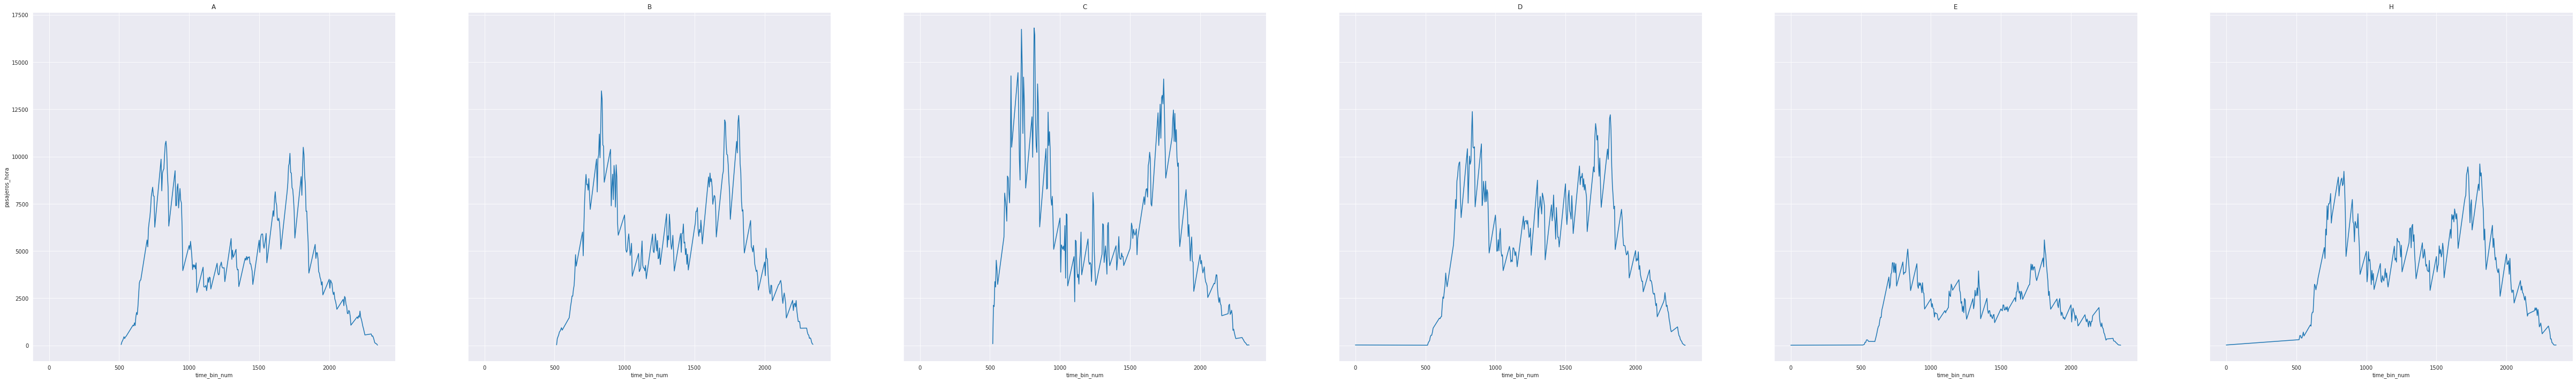

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
fig, axes = plt.subplots(ncols=6, sharex=True,sharey=True, figsize=(85,12))
lineas = ['A','B','C','D','E','H']
for ind in range(6):
  sns.lineplot(data=maximas_cargas[maximas_cargas.Linea == lineas[ind]], x='time_bin_num', y='pasajeros_hora', ax=axes[ind])
  axes[ind].set_title(lineas[ind])

In [73]:
import plotly.express as px
linea = 'E'
fig = px.line(maximas_cargas[maximas_cargas.Linea == linea], x='time_bin_num', y='pasajeros_hora', hover_data=['tramos'], title='Pasajeros por hora - Linea '+linea)
# fig.suptitle('Línea ' + linea)
fig.show()

##Excel con Scatter-charts de máxima carga

In [72]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.chart import (
    ScatterChart,
    Reference, Series
)
# from openpyxl.chart.axis import DateAxis
lineas = ['A', 'B', 'C', 'D', 'E', 'H']
wb = Workbook()
for linea in lineas:
  wb.create_sheet(linea)
  ws = wb[linea]

  rows = dataframe_to_rows(maximas_cargas[maximas_cargas.Linea == linea], index=False)
  rows_len = 0
  for row in rows:
    ws.append(row)
    rows_len += 1

  c1 = ScatterChart()
  c1.title = "Máximas cargas - Linea " + linea
  c1.style = 13
  c1.y_axis.title = 'pasajeros_hora'
  c1.x_axis.title = 'Hora'
  xvalues = Reference(ws, min_col=2, min_row=2, max_row=rows_len)
  values = Reference(ws, min_col=3, min_row=1, max_row=rows_len)
  series = Series(values, xvalues, title_from_data=True)
  # data = Reference(ws, min_col=3, min_row=1, max_col=3, max_row=len(rows))
  c1.series.append(series)
  # c1.add_data(data, titles_from_data=True)
  s2 = c1.series[0]
  s2.smooth = True # Make the line smooth
  ws.add_chart(c1, "A10")
  

wb.save('graficos_maximas_cargas_' + fecha_base + '.xlsx')

## Otros resultados

In [ ]:
pd.DataFrame(cargadf.tramos.unique().tolist()).to_excel("tramos.xlsx")

In [ ]:
# pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)[source]
(pd.pivot_table(cargadf, values="pasajeros", columns="time_bin_num", index="tramos", aggfunc="sum").fillna(0) * 6).to_excel("tramos_y_cargas_por_hora.xlsx")


In [ ]:
df[(df.Estacion == "Constitucion        ") & (df.Hora.apply(lambda hora: hora.hour * 10 + hora.minute).astype(int) < 60)]

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,fichada_repetida,time_bins


#TO DO
Resolver OCUPACION MAXIMA